In [1]:
import sys

sys.path.append('../')

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

import selfies as sf
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt

# Import your custom functions and classes from the vae_module.py
from src.vae_module import flatten
from src.vae_module import VAE
from src.vae_module import train_vae

In [2]:
data = pd.read_csv('../data/test_more_dataNoinionc.csv', header=None, names=['smiles', 'logCMC'])
data.head()

input_smiles_list = data.iloc[:, 0].tolist()
input_selfies_list = list(map(sf.encoder, input_smiles_list))

# Parameters for encoding
max_len = max(sf.len_selfies(s) for s in input_selfies_list)
alphabet = sf.get_alphabet_from_selfies(input_selfies_list)
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))
vocab_stoi = {symbol: idx for idx, symbol in enumerate(alphabet)}
vocab_itos = {idx: symbol for symbol, idx in vocab_stoi.items()}

# Convert SELFIES to one-hot encoding
input_one_hot_arr = np.array([sf.selfies_to_encoding(s, vocab_stoi, pad_to_len=max_len)[1] for s in input_selfies_list])
input_one_hot_arr


## Convert the "input_one_hot_arr" dataset to tensor
x_train = torch.tensor(input_one_hot_arr, dtype=torch.float32)
x_train


# Flatten the input data using the custom 'flatten' function
# This function takes a 3D tensor 'x_train' and reshapes it into a 2D tensor
width, height, input_dim, flattened_dataset = flatten(x_train)

# Define hyperparameters
batch_size = 64  # Batch size for training
latent_dim = 32  # Dimensionality of the latent space
num_epochs = 1000  # Number of training epochs

# Create a PyTorch dataset and data loader for training
train_dataset = TensorDataset(flattened_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a VAE model instance
vae = VAE(input_dim, latent_dim)


input_dim_pretrained = 4920
# Load the pre-trained VAE model
pretrained_vae = VAE(input_dim_pretrained, latent_dim)  # Use the appropriate input_dim_pretrained
pretrained_vae.load_state_dict(torch.load('../models/pretrained_vae.pt'))


# Transfer weights to the corresponding layers in your current VAE model
with torch.no_grad():
    # Transfer encoder weights
    vae.encoder[0].weight.copy_(pretrained_vae.encoder[0].weight[:, :input_dim])

    # Transfer decoder weights
    vae.decoder[2].weight.copy_(pretrained_vae.decoder[2].weight[:input_dim, :])

    # Update the decoder bias dimensions
    vae.decoder[2].bias.copy_(pretrained_vae.decoder[2].bias[:input_dim])


#Define the optimizer for training the VAE model
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Train the VAE model using the 'train_vae' function
train_vae(vae, train_loader, optimizer, num_epochs)

Epoch [1/1000], Loss: 14122.58515625
Epoch [2/1000], Loss: 12994.91845703125
Epoch [3/1000], Loss: 12062.387890625
Epoch [4/1000], Loss: 11511.06748046875
Epoch [5/1000], Loss: 10807.580859375
Epoch [6/1000], Loss: 10158.85888671875
Epoch [7/1000], Loss: 9437.6541015625
Epoch [8/1000], Loss: 8813.658203125
Epoch [9/1000], Loss: 8383.2052734375
Epoch [10/1000], Loss: 8046.410009765625
Epoch [11/1000], Loss: 7689.31943359375
Epoch [12/1000], Loss: 7432.528173828125
Epoch [13/1000], Loss: 7073.659716796875
Epoch [14/1000], Loss: 6571.3634765625
Epoch [15/1000], Loss: 5782.906396484375
Epoch [16/1000], Loss: 5118.7748046875
Epoch [17/1000], Loss: 4823.064013671875
Epoch [18/1000], Loss: 4640.773828125
Epoch [19/1000], Loss: 4490.721875
Epoch [20/1000], Loss: 4359.50791015625
Epoch [21/1000], Loss: 4282.837109375
Epoch [22/1000], Loss: 4212.3072265625
Epoch [23/1000], Loss: 4171.699487304688
Epoch [24/1000], Loss: 4115.333642578125
Epoch [25/1000], Loss: 4064.47890625
Epoch [26/1000], Loss:

In [3]:
# Generate molecules from the trained VAE
vae.eval()
num_samples = 500  # generate a sample
with torch.no_grad():
    latent_samples = torch.randn(num_samples, latent_dim)
    generated_molecules = vae.decoder(latent_samples)

generated_molecules


vae.eval()  # Set the VAE model to evaluation mode
with torch.no_grad():
    # Pass the generated molecules through the encoder
    encoded_latent_generated = vae.encoder(generated_molecules)

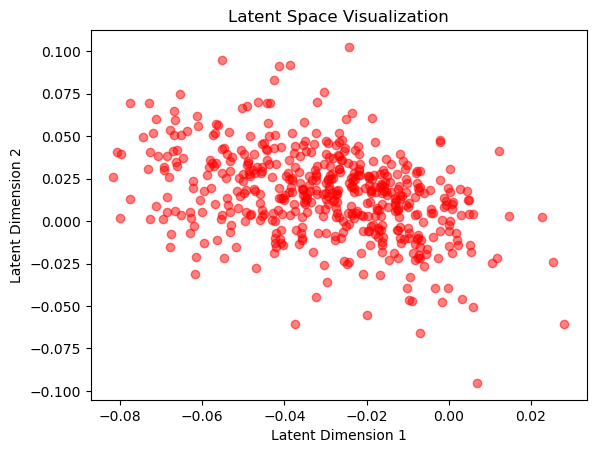

In [4]:
# Scatter plot for visualization
plt.scatter(encoded_latent_generated[:, 0], encoded_latent_generated[:, 1], alpha=0.5, color='red')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.savefig('VAE_space.png')
plt.show()

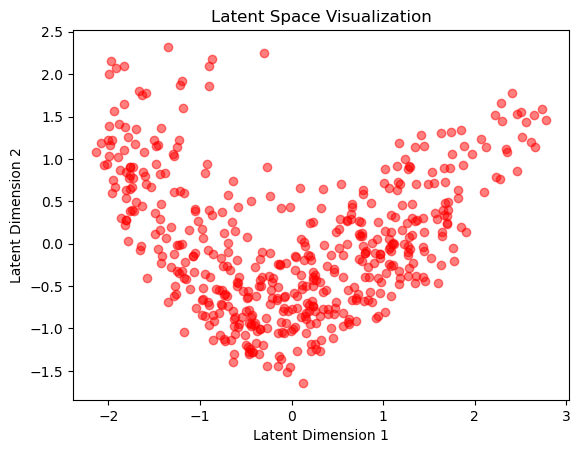

In [5]:
from sklearn.decomposition import PCA

# Perform PCA on the encoded latent space
pca = PCA(n_components=2)
encoded_latent_generated_pca = pca.fit_transform(encoded_latent_generated)

# Scatter plot for visualization
plt.scatter(encoded_latent_generated_pca[:, 0], encoded_latent_generated_pca[:, 1], alpha=0.5, color='red')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.savefig('VAE_space_with_pretrain.png')
plt.show()


In [6]:
### Without the pre-trained model

# Create a VAE model instance
vae_no_pretrain = VAE(input_dim, latent_dim)

#Define the optimizer for training the VAE model
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Train the VAE model using the 'train_vae' function
train_vae(vae_no_pretrain, train_loader, optimizer, num_epochs)

Epoch [1/1000], Loss: 52443.750390625
Epoch [2/1000], Loss: 52413.98984375
Epoch [3/1000], Loss: 52470.958984375
Epoch [4/1000], Loss: 52452.89921875
Epoch [5/1000], Loss: 52465.41640625
Epoch [6/1000], Loss: 52433.705078125
Epoch [7/1000], Loss: 52458.355859375
Epoch [8/1000], Loss: 52459.08046875
Epoch [9/1000], Loss: 52443.61484375
Epoch [10/1000], Loss: 52470.94609375
Epoch [11/1000], Loss: 52418.459375
Epoch [12/1000], Loss: 52468.084375
Epoch [13/1000], Loss: 52444.405859375
Epoch [14/1000], Loss: 52447.35078125
Epoch [15/1000], Loss: 52458.18125
Epoch [16/1000], Loss: 52409.91328125
Epoch [17/1000], Loss: 52454.748828125
Epoch [18/1000], Loss: 52439.36640625
Epoch [19/1000], Loss: 52463.29453125
Epoch [20/1000], Loss: 52468.98359375
Epoch [21/1000], Loss: 52450.43515625
Epoch [22/1000], Loss: 52461.291796875
Epoch [23/1000], Loss: 52454.301171875
Epoch [24/1000], Loss: 52429.93828125
Epoch [25/1000], Loss: 52444.696484375
Epoch [26/1000], Loss: 52442.44375
Epoch [27/1000], Loss:

In [7]:
# Generate molecules from the trained VAE
vae_no_pretrain.eval()
num_samples = 500  # generate a sample
with torch.no_grad():
    latent_samples = torch.randn(num_samples, latent_dim)
    generated_molecules_no_pretrain = vae_no_pretrain.decoder(latent_samples)

generated_molecules_no_pretrain


vae.eval()  # Set the VAE model to evaluation mode
with torch.no_grad():
    # Pass the generated molecules through the encoder
    encoded_latent_generated_no_pretrain = vae.encoder(generated_molecules_no_pretrain)

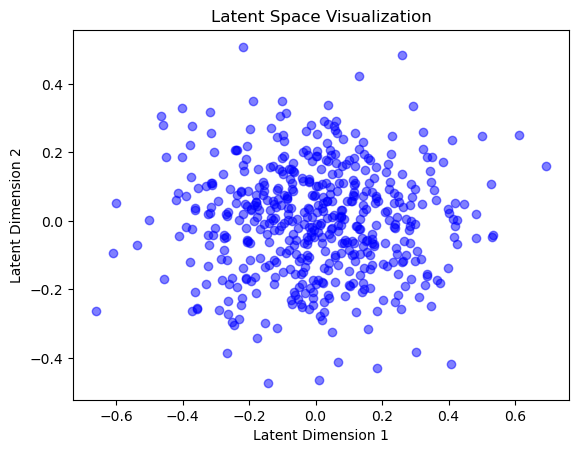

In [8]:
from sklearn.decomposition import PCA

# Perform PCA on the encoded latent space
pca = PCA(n_components=2)
encoded_latent_generated_no_pretrain_pca = pca.fit_transform(encoded_latent_generated_no_pretrain)

# Scatter plot for visualization
plt.scatter(encoded_latent_generated_no_pretrain_pca[:, 0], encoded_latent_generated_no_pretrain_pca[:, 1], alpha=0.5, color='blue')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.savefig('VAE_space_without_pretrain.png')
plt.show()

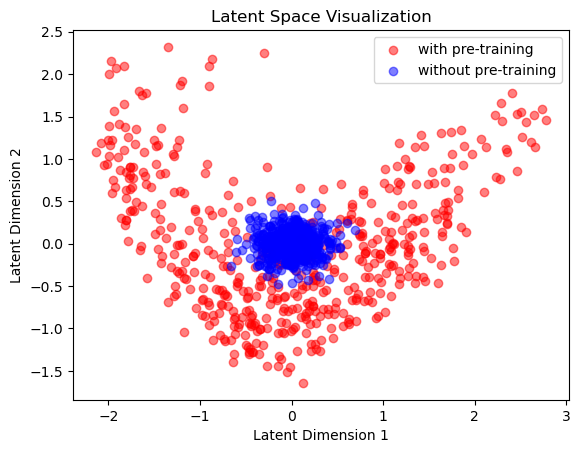

In [9]:
import matplotlib.pyplot as plt

# Scatter plot for visualization
plt.scatter(encoded_latent_generated_pca[:, 0], encoded_latent_generated_pca[:, 1], alpha=0.5, color='red', label='with pre-training')
plt.scatter(encoded_latent_generated_no_pretrain_pca[:, 0], encoded_latent_generated_no_pretrain_pca[:, 1], alpha=0.5, color='blue', label='without pre-training')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')

# Display the legend
plt.legend()

# Save the plot as a PNG file
plt.savefig('VAE_latent_space_comparison.png')

# Show the plot
plt.show()

In [10]:
def generated_molecules_to_smiles(generated_molecules):
    # Reshape satisfying_molecules_tensor back to a 3D tensor
    generated_molecules_tensor_3d = generated_molecules.view(-1, width, height)
    # Convert the PyTorch 3D tensor to a NumPy array
    generated_molecules_numpy = generated_molecules_tensor_3d.numpy()

    max_values = np.max(generated_molecules_numpy, axis=2, keepdims=True)
    generated_data = np.where(generated_molecules_numpy == max_values, 1, 0)

    ### Reproduce SMILES list and visualize the output images
    output_smiles_list = []
    for i in range (0,len(generated_data)):
        sm = sf.decoder(sf.encoding_to_selfies(generated_data[i].tolist(), vocab_itos, enc_type="one_hot"))
        output_smiles_list.append(sm)

    return output_smiles_list

In [11]:
from src.pretrainedmodel import GNNmodel

In [12]:
path = '../models/GCN_early_stop'
prediction_model = GNNmodel(path = path)

In [ ]:
##Reinforcement learning with reward based approach

In [13]:
# Define a reward function
def calculate_reward(property_value):
    # Define the threshold for the property value
    threshold = -1.0

    # Calculate the reward
    if property_value < threshold:
        return 10  # Positive reward for good molecules (>-1.0 property)
    else:
        return -10  # No reward for molecules with property <= 1.0

# Define hyperparameters for reinforcement learning
num_episodes = 2000  # Number of episodes for training
learning_rate = 0.001

# Define the optimizer for updating the VAE model
vae_optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Reinforcement learning loop
for episode in range(num_episodes):
    # Generate a molecule using the VAE model
    vae.eval()
    with torch.no_grad():
        latent_sample = torch.randn(1, latent_dim)
        generated_molecule = vae.decoder(latent_sample)

    # Calculate the property of the generated molecule using the prediction model
    predicted_property = prediction_model.predict(generated_molecules_to_smiles(generated_molecule))[0]

    # Calculate the reward based on the property value
    reward = calculate_reward(predicted_property)

    # Update the VAE model using reinforcement learning
    vae.train()
    vae_optimizer.zero_grad()

    # Forward pass: Get reconstruction, mean, and log variance
    recon_x, mu, log_var = vae(generated_molecule)

    # Calculate the VAE loss
    loss = vae.vae_loss(recon_x, generated_molecule, mu, log_var)
    # Add the reward term to the loss
    total_loss = loss - reward

    # Backpropagate and update the VAE model
    total_loss.backward()
    vae_optimizer.step()

    # Print episode information
    print(f"Episode {episode + 1}/{num_episodes}: Reward = {reward}, Property = {predicted_property}")

Episode 1/2000: Reward = -10, Property = 0.3827565312385559
Episode 2/2000: Reward = -10, Property = 0.850700855255127
Episode 3/2000: Reward = 10, Property = -1.9211543202400208
Episode 4/2000: Reward = 10, Property = -2.2066659927368164
Episode 5/2000: Reward = 10, Property = -2.2507026195526123
Episode 6/2000: Reward = 10, Property = -2.3532875776290894
Episode 7/2000: Reward = 10, Property = -2.2790536880493164
Episode 8/2000: Reward = -10, Property = -0.49453768134117126
Episode 9/2000: Reward = -10, Property = 0.19116013124585152
Episode 10/2000: Reward = -10, Property = -0.023392070084810257
Episode 11/2000: Reward = 10, Property = -1.6457754373550415
Episode 12/2000: Reward = -10, Property = 0.11592597141861916
Episode 13/2000: Reward = -10, Property = 0.08489307202398777
Episode 14/2000: Reward = 10, Property = -1.4889039397239685
Episode 15/2000: Reward = 10, Property = -2.037958860397339
Episode 16/2000: Reward = 10, Property = -1.5870935320854187
Episode 17/2000: Reward = -

In [14]:
# Generate molecules that satisfy the property threshold (<-1.0)
vae.eval()
num_samples = 500  # Adjust the number of samples as needed
satisfying_molecules = []
predicted_properties = []

for _ in range(num_samples):
  with torch.no_grad():
    latent_sample = torch.randn(1, latent_dim)
    generated_molecule = vae.decoder(latent_sample)
  predicted_property = prediction_model.predict(generated_molecules_to_smiles(generated_molecule))[0]

  # Check if the property is above the threshold
  if predicted_property < -1.0:
    satisfying_molecules.append(generated_molecule)
    predicted_properties.append(predicted_property)

In [15]:
# Stack the tensors
satisfying_molecules_tensor = torch.cat(satisfying_molecules, dim=0)
satisfying_molecules_tensor

tensor([[4.3828e-06, 3.0140e-06, 3.0964e-06,  ..., 3.8178e-06, 3.7361e-06,
         9.9403e-01],
        [3.4578e-09, 1.1908e-09, 1.4339e-09,  ..., 1.4421e-09, 2.1972e-09,
         1.0000e+00],
        [3.1424e-07, 1.9200e-07, 2.0146e-07,  ..., 1.8136e-07, 2.2212e-07,
         9.9998e-01],
        ...,
        [2.8387e-10, 1.3563e-10, 1.1083e-10,  ..., 1.1243e-10, 1.6143e-10,
         1.0000e+00],
        [1.4134e-07, 6.9830e-08, 1.2793e-07,  ..., 8.2090e-08, 8.5051e-08,
         1.0000e+00],
        [6.1226e-10, 2.9548e-10, 6.1638e-10,  ..., 3.7924e-10, 3.5802e-10,
         1.0000e+00]])

In [16]:
combined_tensor_rl = torch.cat(satisfying_molecules, dim=0)
combined_tensor_rl

tensor([[4.3828e-06, 3.0140e-06, 3.0964e-06,  ..., 3.8178e-06, 3.7361e-06,
         9.9403e-01],
        [3.4578e-09, 1.1908e-09, 1.4339e-09,  ..., 1.4421e-09, 2.1972e-09,
         1.0000e+00],
        [3.1424e-07, 1.9200e-07, 2.0146e-07,  ..., 1.8136e-07, 2.2212e-07,
         9.9998e-01],
        ...,
        [2.8387e-10, 1.3563e-10, 1.1083e-10,  ..., 1.1243e-10, 1.6143e-10,
         1.0000e+00],
        [1.4134e-07, 6.9830e-08, 1.2793e-07,  ..., 8.2090e-08, 8.5051e-08,
         1.0000e+00],
        [6.1226e-10, 2.9548e-10, 6.1638e-10,  ..., 3.7924e-10, 3.5802e-10,
         1.0000e+00]])

In [17]:
vae.eval()  # Set the VAE model to evaluation mode
with torch.no_grad():
    # Pass the generated molecules through the encoder
    encoded_latent_generated_rl = vae.encoder(combined_tensor_rl)

encoded_latent_generated_rl

tensor([[-2.4011e-03,  2.9791e-02, -7.1681e-03,  ..., -2.1669e-02,
         -1.5061e+00,  2.5029e-02],
        [-1.3911e-02,  1.6135e-01,  1.2372e-01,  ...,  7.1907e-03,
         -6.5550e-01, -5.1631e-02],
        [-8.0632e-04,  3.6682e-02,  2.3706e-03,  ..., -5.0843e-03,
         -1.5337e+00,  3.1922e-02],
        ...,
        [ 5.7325e-04,  9.6555e-02,  5.9842e-02,  ...,  1.9006e-02,
         -1.2260e+00, -1.3284e-02],
        [-3.3909e-04,  1.0030e-01,  8.7722e-02,  ...,  4.9410e-03,
         -3.8702e-01, -5.9335e-02],
        [-1.6438e-02, -1.8983e-02,  1.0962e-02,  ..., -7.2328e-03,
         -1.1394e-01, -3.9038e-02]])

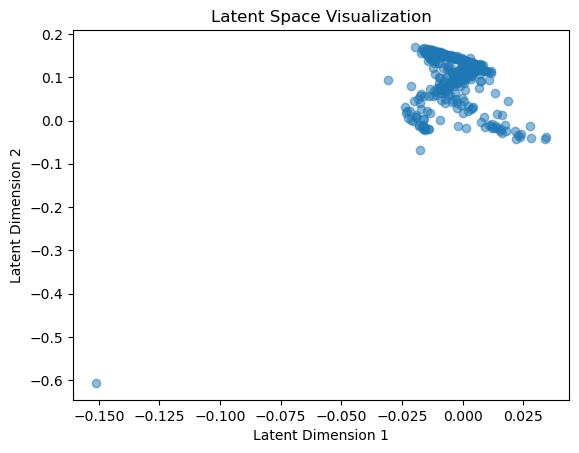

In [18]:
# Scatter plot for visualization
plt.scatter(encoded_latent_generated_rl[:, 0], encoded_latent_generated_rl[:, 1], alpha=0.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

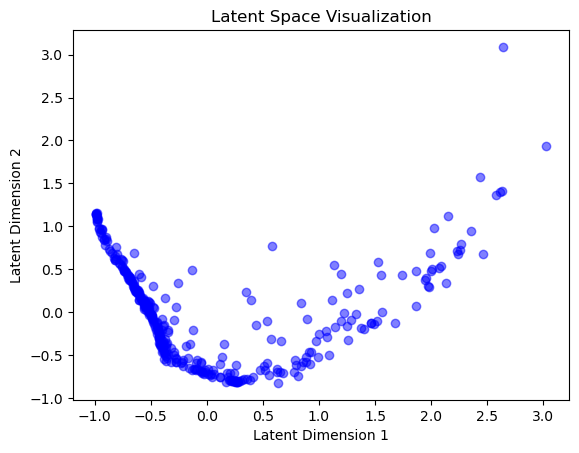

In [19]:
# Perform PCA on the encoded latent space
pca = PCA(n_components=2)
encoded_latent_generated_rl_pca = pca.fit_transform(encoded_latent_generated_rl)

# Scatter plot for visualization
plt.scatter(encoded_latent_generated_rl_pca[:, 0], encoded_latent_generated_rl_pca[:, 1], alpha=0.5, color='blue')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

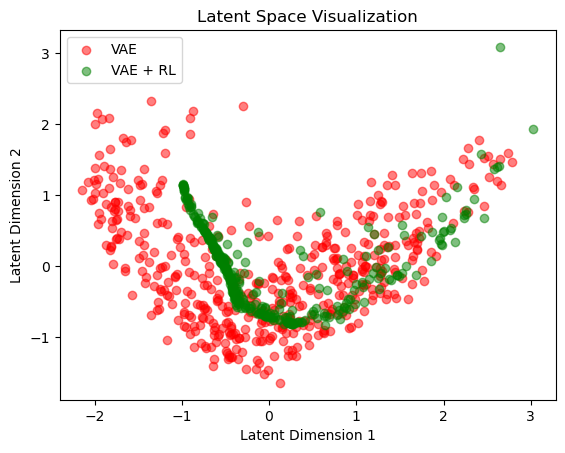

In [20]:
import matplotlib.pyplot as plt

# Scatter plot for visualization
plt.scatter(encoded_latent_generated_pca[:, 0], encoded_latent_generated_pca[:, 1], alpha=0.5, color='red', label='VAE')
plt.scatter(encoded_latent_generated_rl_pca[:, 0], encoded_latent_generated_rl_pca[:, 1], alpha=0.5, color='green', label='VAE + RL')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')

# Display the legend
plt.legend()

# Save the plot as a PNG file
plt.savefig('latent_space.png')

# Show the plot
plt.show()

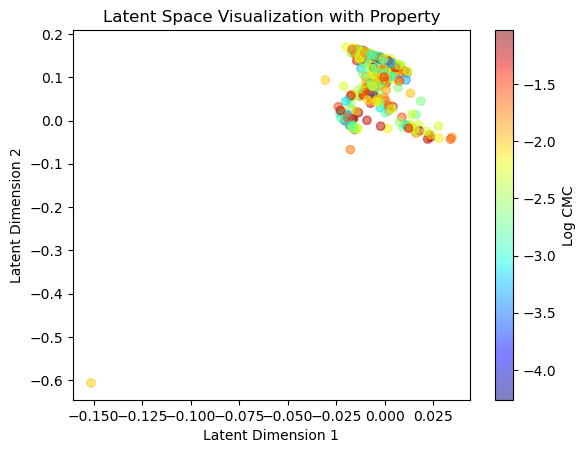

In [21]:
# Scatter plot with color map for visualization
plt.scatter(encoded_latent_generated_rl[:, 0], encoded_latent_generated_rl[:, 1], c=predicted_properties, cmap='jet', alpha=0.5)
plt.colorbar(label='Log CMC')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization with Property')
plt.savefig('VAE+RL_heatmap.png')
plt.show()

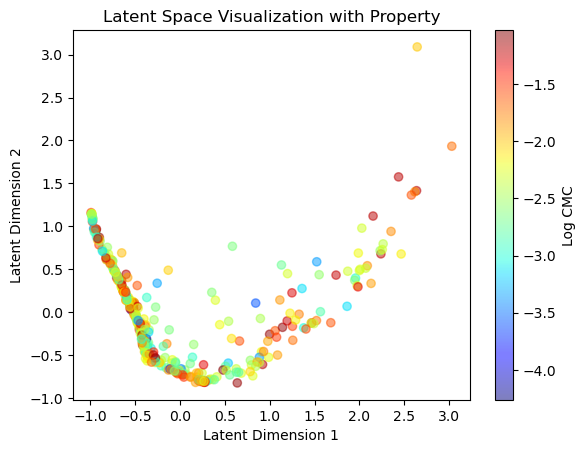

In [24]:
# Perform PCA on the encoded latent space
pca = PCA(n_components=2)
encoded_latent_generated_rl_pca = pca.fit_transform(encoded_latent_generated_rl)

# Scatter plot for visualization
plt.scatter(encoded_latent_generated_rl_pca[:, 0], encoded_latent_generated_rl_pca[:, 1], c=predicted_properties, cmap='jet', alpha=0.5)
plt.colorbar(label='Log CMC')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization with Property')
plt.savefig('VAE+RL_heatmap.png')
plt.show()